## Guide - pyLEnM package
# Case 4 - Well Optimization
Welcome to the demonstration notebook where we'll go over an example for well optimization to select a subset of wells to capture the spatiotemporal variability of groundwater table using the **pyLEnM** package!<br>
Let’s get started!

## Setup
Make sure to install pyLEnM from https://pypi.org/project/pylenm/ by running `pip install pylenm` in your environment terminal. Once completed, you should be able to import the package. Note: to update to the latest version of pylenm run: `pip install pylenm --upgrade`

In [1]:
# Basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# PyLenm
import pylenm
from pylenm import functions, usage

# GIS data layers
from pyproj import Transformer

## Load Well Time Series Data + Preprocess

In [2]:
# Load and process well time-series data
concentration_data = pd.read_csv('data/FASB_Data_thru_3Q2015.csv')
construction_data = pd.read_excel('data/FASB Well Construction Info.xlsx')
pylenm = functions(concentration_data)
pylenm.simplify_data(inplace=True)
pylenm.setConstructionData(construction_data)

Successfully imported the data!

Successfully imported the construction data!



Data summary for water table

In [3]:
WT_details = pylenm.get_analyte_details('DEPTH_TO_WATER')
WT_details

,Start Date,End Date,Date Range (days),Unique samples
Well Name,,,,
FSB 94D,1990-01-01,1990-10-08,280,4
FSB 95D,1990-01-01,1990-10-08,280,4
FSB 77,1990-01-01,2006-10-16,6132,122
FSB111C,1990-01-01,2006-10-17,6133,115
FSB105C,1990-01-01,2006-10-19,6135,127
...,...,...,...,...
FSB146D,2015-04-29,2015-09-09,133,9
FSB145D,2015-04-30,2015-09-09,132,9
FSB143D,2015-05-04,2015-09-09,128,9


Select wells that have enough and recent samples

In [4]:
n_samples = WT_details['Unique samples']
end_date = WT_details['End Date']
start_date = WT_details['Start Date']
well_names  = WT_details.index
well_enough = well_names[n_samples>20]

In [5]:
well_recent = well_names[end_date> datetime.strptime('2015-01-01', '%Y-%m-%d').date()]
well_old    = well_names[start_date< datetime.strptime('2006-01-01', '%Y-%m-%d').date()]

Temporal interpolation of the time series at equal frequency

In [6]:
wt_interp = pylenm.interpolate_wells_by_analyte('DEPTH_TO_WATER', frequency='1M', rm_outliers=True, z_threshold=3)

Select the upper aquifer wells and the wells that have enough samples

52 wells


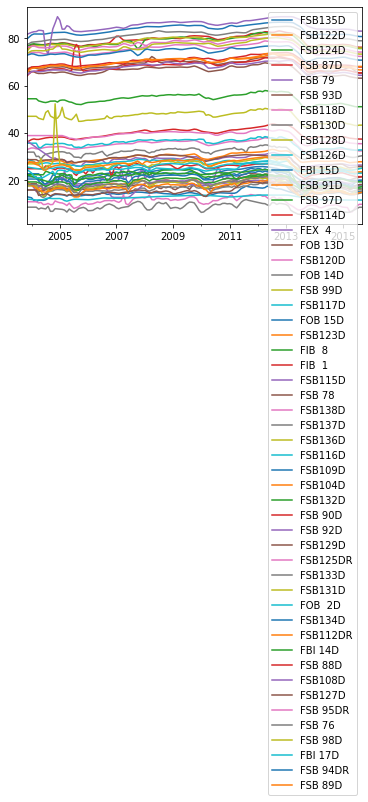

In [7]:
active = list(np.unique(pylenm.filter_by_column(pylenm.get_Construction_Data(), col='WELL_USE', equals=['ACTIVE']).index))
upper_wells = list(np.unique(pylenm.filter_by_column(pylenm.get_Construction_Data(), col='AQUIFER', equals=['UAZ_UTRAU']).index))
well_only_D = list(set(upper_wells) & set(wt_interp.columns)& set(well_enough)& set(well_recent)& set(well_old) & set(active))
wt_interp = wt_interp[well_only_D]
wt_interp.plot()
print(wt_interp.shape[1], "wells")

Let's remove the 'bad' time series wells

49 wells


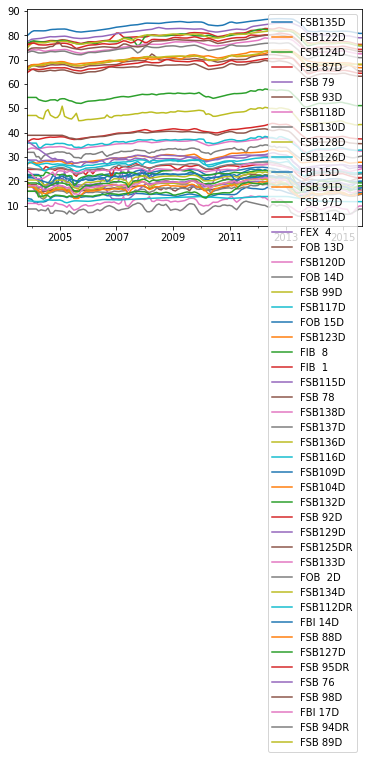

In [8]:
bad_ones = ['FSB108D', 'FSB131D', 'FSB 90D']
wt_interp = wt_interp.drop(columns=bad_ones)
wt_interp.plot()
print(wt_interp.shape[1], "wells")

In [9]:
# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

# Convert to meters
wt_interp = wt_interp * 0.3048

## Well Location Data

In [10]:
well_info = pylenm.get_Construction_Data()

Match the well indecies between the time series and locations

In [11]:
shared_wells = list(set(well_info.index) & set(wt_interp.columns))
wt_interp = wt_interp[shared_wells]
# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

well_info = well_info.T[shared_wells]
# Reorder columns to be in alphabetical order
well_info = well_info.reindex(sorted(well_info.columns), axis=1)
well_info = well_info.T

In [12]:
transformer = Transformer.from_crs("epsg:4326", "epsg:26917") # Latitude/Longitude to UTM
UTM_x, UTM_y = transformer.transform(well_info.LATITUDE, well_info.LONGITUDE)

Take out the ground-surface elevation, and compute the water table elevation

In [13]:
elev = well_info.REFERENCE_ELEVATION
elev.index = well_info.index
elev = elev.T
elev = elev * 0.3048 # convert to meters

# Now this is the water table elevation (GROUND_ELEVATION - DEPTH_TO_WATER)
wt_interp = elev.values - wt_interp

# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

In [14]:
X = np.vstack((UTM_x, UTM_y, elev.values)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation'])

Create our grid for mapping Water Table data

In [15]:
# Grid information
class structtype():
    pass
grid     = structtype()
grid.n   = np.array([150,140])  # Image dimension
grid.d   = np.array([10,10]) # pixel size in degree 
grid.xy0 = np.array([UTM_x.min(), UTM_y.min()]) # zero point in the coordinates

# X and Y coordiantes of the grid location
x_loc = np.zeros(grid.n)
for i in range(np.shape(x_loc)[0]):
    for j in range(np.shape(x_loc)[1]):
        x_loc[i,j] = (j-0.5)*grid.d[0]+grid.xy0[0]
        
y_loc = np.zeros(grid.n)
for i in range(np.shape(y_loc)[0]):
    for j in range(np.shape(y_loc)[1]):
        y_loc[i,j] = (i-0.5)*grid.d[1]+grid.xy0[1] 

XX = np.vstack([x_loc.flatten(), y_loc.flatten()]).T
XX = pd.DataFrame(XX, columns=['Easting', 'Northing'])

Seperate data into individual time steps

In [16]:
dateRanges = wt_interp.index
values = {}
for date in dateRanges:
    values[date] = np.array(wt_interp.loc[date])

currentDate = dateRanges[0]
y = values[currentDate]

## Map generation + Optimization

In [17]:
usage.get_FunctionDescription('interpolate_topo')


interpolate_topo (X, y, xx, ft=['Elevation'], regression='linear', model=None, smooth=True):
Description: 
    Interpolate the water table as a function of topographic metrics using Gaussian Process. Uses regression to generate trendline adds the values to the GP map.
Parameters:
    X (dataframe): training values. Must include "Easting" and "Northing" columns.
    y (array of floats): array of size (number of wells) where each value corresponds to a concentration value at a well.
    xx (array of floats): prediction locations
    ft (list of stings): feature names to train on
    regression (string): choice between 'linear' for linear regression, 'rf' for random forest regression, 'ridge' for ridge regression, or 'lasso' for lasso regression.
    model (GP model): model to fit
    smooth (bool): flag to toggle WhiteKernel on and off



Generate a 'Reference Field' Water table map using the data from timestep `currentDate`

In [18]:
y_map, r_map, residuals, lr_trend = pylenm.interpolate_topo(X, y, XX, ft=['Elevation'], smooth=True)

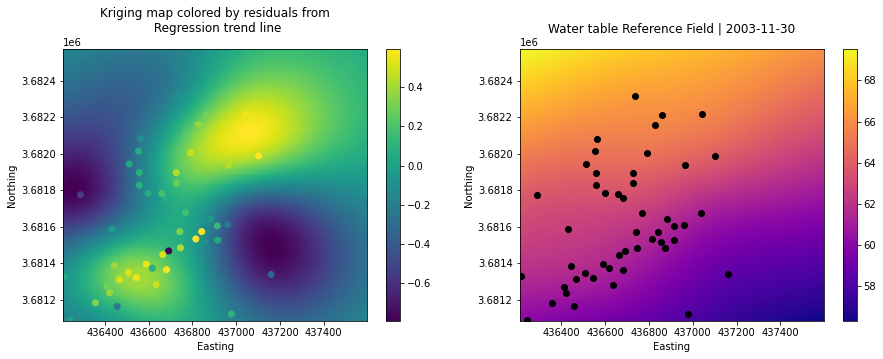

In [19]:
# Plot all result details
fig, ax = plt.subplots(1,2, figsize=(15,5))
xx = np.array(XX)
titles = ["Kriging map colored by residuals from\n Regression trend line", str("Water table Reference Field | {}".format(currentDate.date()))]
map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                r_map.reshape(x_loc.shape))
fig.colorbar(map_0, ax=ax[0])
map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax[1])
colors=[residuals, 'black']
for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c=colors[i], alpha=1)
    ax[i].set_xlabel("Easting")
    ax[i].set_ylabel("Northing")
    ax[i].set_title(titles[i],y=1.04)
fig.show()

Select initial wells + determine its index number respectively

In [20]:
initial_wells = ['FSB 95DR','FSB130D','FSB 79', 'FSB 97D', 'FSB126D']
well_list = list(wt_interp.columns)
initial_idx = []
for i in initial_wells:
  initial_idx.append(well_list.index(i))
initial_indices = initial_idx.copy()
print(initial_idx)

[20, 41, 12, 21, 37]


In [21]:
usage.get_FunctionDescription('get_Best_Wells')


get_Best_Wells (X, y, xx, ref, initial, max_wells, ft=['Elevation'], regression='linear', verbose=True, smooth=True, model=None):
Description: 
    Optimization function to select a subset of wells as to minimizes the MSE from a reference map
Parameters:
    X (array): array of dimension (number of wells, 2) where each element is a pair of UTM coordinates.
    y (array of floats): array of size (number of wells) where each value corresponds to a concentration value at a well.
    xx (array of floats): prediction locations
    ref (array): reference values for xx locations
    max_wells (int): number of wells to optimize for
    ft (list of stings): feature names to train on
    regression (string): choice between 'linear' for linear regression, 'rf' for random forest regression, 'ridge' for ridge regression, or 'lasso' for lasso regression.
    initial (list of ints): indices of wells as the starting wells for optimization
    verbose (bool): flag to toggle details of the well selecti

Run well selection optimization using:<br>
- y_map as the reference
- 'FSB 95DR','FSB130D','FSB 79', 'FSB 97D', and 'FSB126D' as the starting wells
- a maximum of 20 wells

In [22]:
max_wells = 20
selected_wells_idx, errors = pylenm.get_Best_Wells(X=X[['Easting','Northing']], y=y, xx=XX[['Easting','Northing']], ref=y_map, initial=initial_idx, max_wells=max_wells, ft=['Elevation'], regression='linear')

# of wells to choose from:  44
Selected well: 40 with a MSE error of 0.11270713912928977

# of wells to choose from:  43
Selected well: 1 with a MSE error of 0.1053673237456414

# of wells to choose from:  42
Selected well: 22 with a MSE error of 0.10308634727154911

# of wells to choose from:  41
Selected well: 39 with a MSE error of 0.10308728166193584

# of wells to choose from:  40
Selected well: 19 with a MSE error of 0.10347413469091983

# of wells to choose from:  39
Selected well: 11 with a MSE error of 0.10277946509898811

# of wells to choose from:  38
Selected well: 0 with a MSE error of 0.10331202862190668

# of wells to choose from:  37
Selected well: 35 with a MSE error of 0.103556042519814

# of wells to choose from:  36
Selected well: 2 with a MSE error of 0.10321102716823348

# of wells to choose from:  35
Selected well: 28 with a MSE error of 0.10240623116148857

# of wells to choose from:  34
Selected well: 36 with a MSE error of 0.1061568825161655

# of wells to cho

<AxesSubplot:>

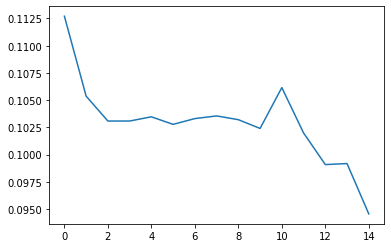

In [26]:
pd.Series(errors).plot()

In [28]:
# Interpolate using selected wells 
pred_map, r_map, residuals, lr_trend = pylenm.interpolate_topo(X.iloc[selected_wells_idx,:], y[selected_wells_idx], XX, ft=['Elevation'], regression='linear', smooth=True)

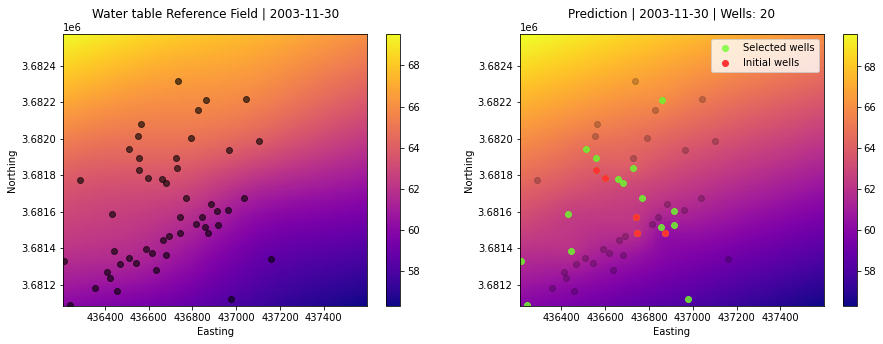

In [30]:
# Plot all result details
fig, ax = plt.subplots(1,2, figsize=(15,5))
xx = np.array(XX)
titles = [str("Water table Reference Field | {}".format(currentDate.date())), str('Prediction | {} | Wells: {}'.format(currentDate.date(), max_wells))]
map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape),
                cmap='plasma')
ax[0].scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=0.6)
fig.colorbar(map_0, ax=ax[0])
map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                pred_map.reshape(x_loc.shape),
                cmap='plasma',
                vmin=y_map.min(), vmax=y_map.max())
ax[1].scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=0.2)
ax[1].scatter(X.iloc[selected_wells_idx,0], X.iloc[selected_wells_idx,1], c='#75FF33', alpha=0.8, label='Selected wells')
ax[1].scatter(X.iloc[initial_indices,0], X.iloc[initial_indices,1], c='#FF3333', alpha=1, label='Initial wells')
ax[1].legend()
fig.colorbar(map_1, ax=ax[1])
for i in range(2):
    ax[i].set_xlabel("Easting")
    ax[i].set_ylabel("Northing")
    ax[i].set_title(titles[i],y=1.04)
fig.show()

In [31]:
print("Mean Squared Error: {:0.4f}".format(pylenm.mse(y_map, pred_map)))

Mean Squared Error: 0.0946


In [32]:
print("Selected wells:\n")
for i,j in zip(range(max_wells),selected_wells_idx): print(str(i+1) + ". " + well_list[j])

Selected wells:

1. FSB 95DR
2. FSB130D
3. FSB 79
4. FSB 97D
5. FSB126D
6. FSB129D
7. FBI 15D
8. FSB 98D
9. FSB128D
10. FSB 94DR
11. FSB 78
12. FBI 14D
13. FSB124D
14. FBI 17D
15. FSB115D
16. FSB125DR
17. FSB 87D
18. FSB 93D
19. FSB112DR
20. FSB 88D
